In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import  nangs 
import  torch
#import cv2
import io

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.06', '1.11.0+cpu')

In [3]:
from nangs import PDE
import math

K=50

class PeronaMalik(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        
        # compute first-order derivatives
        grads = self.computeGrads(outputs, inputs)
        dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        
        # compute second-order derivatives
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0]        
        dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        #dudas
        dp2dpxdpy=self.computeGrads(dpdx, inputs)[:, 1]
        dp2dpydpx=self.computeGrads(dpdy, inputs)[:, 0]
        
        
        # compute loss
        #dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        return {'pde': dpdx*(-2/K**2)*torch.exp(-(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2)  *((dpdx*dp2dx2)+(dpdy*dp2dpydpx))
                      -dpdy*(-2/K**2)*torch.exp(-(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2)  *((dpdx*dp2dpxdpy)+(dpdy*dp2dy2))
               +torch.exp(  -(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2) * ( dp2dx2+dp2dy2 )-dpdt}
    
pde = PeronaMalik(inputs=('x', 'y', 't'), outputs='p')

In [4]:
n_samples = 60000
print("a")

a


In [5]:
import torch
import random


class BaseSampler():
    def __init__(self, data, n_samples=1, device="cpu"):
        assert isinstance(data, dict), "you must pass a dict with your data"
        self.device = device
        self.data = data
        self.vars = tuple(data.keys())
        self.n_samples = n_samples

    def _sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        sample = self.sample(n_samples)
        return torch.stack([
            sample[var]
            for var in self.vars
        ], axis=-1)

    def sample(self, n_samples=None):
        raise ValueError("you must implement this method")
    
    



class Perona_Sampler(BaseSampler):
    def __init__(self, data, n_samples=1, device="cpu"):
        super().__init__(data, n_samples, device)
        for var, lims in data.items():
            if isinstance(lims, list):
                assert len(
                    lims) == 2, "you must pass a list with the min and max limits"
            elif isinstance(lims, int) or isinstance(lims, float):
                data[var] = [lims, lims]
            else:
                raise ValueError("invalid limits")

    def sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        a={
            
            var: torch.rand(n_samples, device=self.device) *
            (lims[1] - lims[0]) + lims[0]
            for var, lims in self.data.items()
        }
        i=0
        b_list=[]
        for item in range(n_samples):
            b=random.uniform(0,200)
            if i<-1:
                b_list.append(0)
            else:
                b_list.append(b)
            i+=1
            #print(i,b)
            
        
        b_tensor=torch.tensor(b_list,device=self.device)
        #for i in b_tensor:
        #    b_tensor[i]=b
        result={'x':a['x'],'y':a['y'],'t':b_tensor}  
        #print(result)
        return result
    
    
class Perona_Sampler_Ini(BaseSampler):
    def __init__(self, data, n_samples=1, device="cpu"):
        super().__init__(data, n_samples, device)
        for var, lims in data.items():
            if isinstance(lims, list):
                assert len(
                    lims) == 2, "you must pass a list with the min and max limits"
            elif isinstance(lims, int) or isinstance(lims, float):
                data[var] = [lims, lims]
            else:
                raise ValueError("invalid limits")

    def sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        a={
            
            var: torch.rand(n_samples, device=self.device) *
            (lims[1] - lims[0]) + lims[0]
            for var, lims in self.data.items()
        }
        i=0
        b_list=[]
        for item in range(n_samples):
            b=random.uniform(0,200)
            if i<n_samples/5:
                b_list.append(0)
            else:
                b_list.append(b)
            i+=1
            #print(i,b)
            
        
        b_tensor=torch.tensor(b_list,device=self.device)
        #for i in b_tensor:
        #    b_tensor[i]=b
        result={'x':a['x'],'y':a['y'],'t':b_tensor}  
        #print(result)
        return result


In [6]:
# define the sampler

#from nangs import RandomSampler

sampler = Perona_Sampler({
    'x': [0., 200.], 
    'y': [0., 200.],
    't': [0., 200.], 
}, device=device, n_samples=1000)

pde.set_sampler(sampler)
print("a")

a


In [7]:
def cero_f(n_samples):
    return torch.zeros(n_samples)

In [8]:
def f_circle(x,y):
    z = (x - 100)**2 + (y - 100)**2
    for i in range(0,len(z)):
        if z[i] <= 800:
            z[i] = 30
        else: z[i] = 200

    return z

In [9]:
def cart_prod(*args):
    grids =np.meshgrid(*args,indexing='ij')
    return np.stack(grids,axis=-1).reshape(-1,len(args))

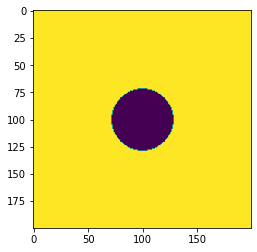

In [10]:
x = np.linspace(0,199,200)

grid=cart_prod(x,x)


xs, ys= grid[:, 0:1], grid[:,1:2]

plt.imshow(f_circle(xs,ys).reshape(200,200))


In [11]:
from nangs import Dirichlet


foto = Dirichlet(
    Perona_Sampler_Ini({'x': [0., 200.], 'y': [0., 200.],'t':0}, device=device, n_samples=n_samples), 
     lambda inputs: {'p' :f_circle(inputs['x'],inputs['y'])},
    name="foto"
)

pde.add_boco(foto)
print("a")

a


In [12]:
from torch import nn
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons,initial_cirlce):
        super().__init__()
        self.ndims=inputs
        self.ndims_spatial=self.ndims-1
        self.domain=[(0,1),(0,1),(0,1)]
        self.initial_condition=initial_cirlce
        self.log_scale = nn.Parameter(torch.tensor(0.0, requires_grad=True))
        
        print('inputs')
        print(inputs)
        print('outputs')
        print(outputs)
        
        self.layer1=nn.Linear(inputs,256)
        self.layer2=nn.Linear(256,256)
        self.layer3=nn.Linear(256,256)
        self.layer4=nn.Linear(256,outputs)
        
        #self.mlp=
    
#    def anzatc(self, u, xs):
#        """ Anzatc-transformation of the model-output needed for binding initial and boundary conditions. """
#        # Get tensor of spatial variables and time-tensor.
#       xs_spatial = xs[:, :self.ndims_spatial]
#        t = xs[:, self.ndims - 1:self.ndims]
#        lower, upper = [lims[0] for lims in self.domain], [lims[1] for lims in self.domain]
#        lower_spatial, upper_spatial = [torch.Tensor(lst[:self.ndims_spatial]).reshape(1, -1).float()
#                                        for lst in (lower, upper)]
#        t0 = lower[-1]

#        # Apply transformation to bind the boundary condition.
#        #if self.boundary_condition is not None:
#        #    u = (u * (torch.prod((xs_spatial - lower_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True) *
#        #              torch.prod((upper_spatial - xs_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True))
#        #             + self.boundary_condition)

#        # Apply transformation to bind the initial condition.
#        if self.initial_condition is not None:
#            _xs_spatial = [xs_spatial[:, i] for i in range(xs_spatial.shape[1])]
#            u = ((nn.Sigmoid()((t - t0) / torch.exp(self.log_scale)) - .5) * u
#                 + self.initial_condition(*_xs_spatial).view(-1, 1))
#        return u
    
    def forward(self, x):
        #print("x foward")
        #print(np.shape(x))
        x1=torch.tan(self.layer1(x))
        
        #print("x1 foward")
        #print(np.shape(x1))
        x2=torch.sin(self.layer2(x1))
        
        #print("x2 foward")
        #print(np.shape(x2))
        x3=F.relu(self.layer3(x2))
        
        #print("x3 foward")
        #print(np.shape(x3))
        x4=self.layer4(x2)
        
        #print("x4 foward")
        #print(np.shape(x4))
        return x4 
    
    

In [13]:
#import torch


#class Sine(torch.nn.Module):
#    def __init__(self):
#        super().__init__()

#    def forward(self, x):
#        return torch.sin(x)


#def block(i, o):
#    fc = torch.nn.Linear(i, o)
#    return torch.nn.Sequential(
#        Sine(),
#        torch.nn.Linear(i, o)
#    )


#class MLP(torch.nn.Module):
#    def __init__(self, inputs, outputs, layers, neurons):
#        super().__init__()
#        
#        fc_in = torch.nn.Linear(inputs, neurons)
#        fc_hidden = [
#            block(neurons, neurons)
#            for layer in range(layers-1)
#        ]
#        fc_out = block(neurons, outputs)
#
#        self.mlp = torch.nn.Sequential(
#            fc_in,
#            *fc_hidden,
#            fc_out
#        )

#    def forward(self, x):
#        return self.mlp(x)

#---------------------------------------------------------------   
    #def anzatc(self, u, xs):
    #    """ Anzatc-transformation of the model-output needed for binding initial and boundary conditions. """
    #    # Get tensor of spatial variables and time-tensor.
    #    xs_spatial = xs[:, :self.ndims_spatial]
    #    t = xs[:, self.ndims - 1:self.ndims]
    #    lower, upper = [lims[0] for lims in self.domain], [lims[1] for lims in self.domain]
    #    lower_spatial, upper_spatial = [torch.Tensor(lst[:self.ndims_spatial]).reshape(1, -1).float()
    #                                    for lst in (lower, upper)]
    #    t0 = lower[-1]

        # Apply transformation to bind the boundary condition.
    #    if self.boundary_condition is not None:
    #        u = (u * (torch.prod((xs_spatial - lower_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True) *
    #                  torch.prod((upper_spatial - xs_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True))
    #                 + self.boundary_condition)

        # Apply transformation to bind the initial condition.
    #    if self.initial_condition is not None:
    #        _xs_spatial = [xs_spatial[:, i] for i in range(xs_spatial.shape[1])]
    #        u = ((nn.Sigmoid()((t - t0) / torch.exp(self.log_scale)) - .5) * u
    #             + self.initial_condition(*_xs_spatial).view(-1, 1))
    #    return u

In [ ]:
# solve

#from nangs import MLP

LR = 1e-2
N_STEPS = 1000
NUM_LAYERS = 6
NUM_HIDDEN = 256
print(len(pde.inputs))
print(len(pde.outputs))

for item in pde.inputs:
    print(item)
for item in pde.outputs:
    print(item)
    
    
mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN,f_circle).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

3
1
x
y
t
p
inputs
3
outputs
1


{'pde': 0.0505, 'foto': 834.42041}:  86%|████████████████████████████████████▊      | 857/1000 [44:08<07:16,  3.05s/it]

In [ ]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

In [24]:
x = np.linspace(0,199,200)
y = np.linspace(0,199,200)

t=0

grid=cart_prod(x,y,t)
xs, ys= grid[:, 0:1], grid[:,1:2]

(200, 200)
float64


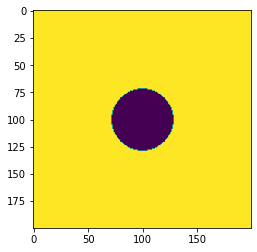

In [25]:
print(f_circle(xs,ys).reshape(200,200).shape)
print(f_circle(xs,ys).reshape(200,200).dtype)
plt.imshow(f_circle(xs,ys).reshape(200,200))


In [26]:

X = torch.from_numpy(grid).float().to(device)
image_final =  pde.eval(X)

xs, ys= grid[:, 0:1], grid[:,1:2]
print(image_final.shape)
print(image_final.dtype)

#plt.imshow(f_circle(xs,ys).reshape(200,200))

torch.Size([40000, 1])
torch.float32


In [27]:
imashow=image_final.reshape(200,200)

In [28]:
def float_to_int(imashow):
    for i in range(len(imashow)):
        for j in range (len(imashow)):
            imashow[i][j]=int(imashow[i][j])

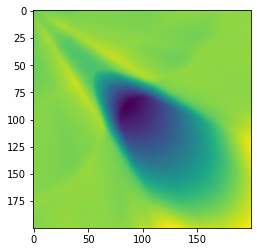

In [29]:
#float_to_int(imashow)
plt.imshow(imashow)

In [22]:
print(imashow)

tensor([[189.4071, 190.5378, 192.1863,  ..., 200.7794, 200.8558, 200.9323],
        [192.1028, 192.9054, 194.2007,  ..., 200.8908, 200.9615, 201.0352],
        [193.0987, 193.8578, 194.6907,  ..., 201.0257, 201.0966, 201.1674],
        ...,
        [198.9901, 199.5770, 199.8518,  ..., 217.5974, 218.0131, 218.4287],
        [199.0198, 199.6068, 199.8882,  ..., 218.1409, 218.5565, 218.9722],
        [199.0496, 199.6365, 199.9246,  ..., 218.6835, 219.1000, 219.5157]])
